# 3_2 choose_learning_machine_models with TOMEK


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#load the file 
data = pd.read_csv('../data/cleaned_data/cleaned_data.csv')
data.head()


,senior_citizen,partner,dependents,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,...,internet_service_Fiber optic,internet_service_No,contract_Month-to-month,contract_One year,contract_Two year,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,churn
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,No
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,No
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,1,Yes
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,1,0,1,0,0,0,No
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,0,0,1,0,Yes


In [3]:
data.shape

(7032, 26)

### x/y split

In [4]:
#separate the features from the labels
y = data['churn']
X = data.drop(['churn'], axis=1)

In [5]:
# change the type of 'y'
y.dtypes

dtype('O')

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
display(y_train.value_counts())
display(y_test.value_counts())

churn
No     4130
Yes    1495
Name: count, dtype: int64

churn
No     1033
Yes     374
Name: count, dtype: int64

#### It is imbalanced,so it needs up/down sampling or TOMEK

In [9]:
from imblearn.under_sampling import TomekLinks

# Create the TomekLinks object
tomek = TomekLinks()

# Apply Tomek Links to resample the data
X_resampled, y_resampled = tomek.fit_resample(X_train, y_train)


In [10]:
X_resampled.shape

(5217, 25)

In [11]:
class_counts = y_resampled.value_counts()
print(class_counts)

churn
No     3722
Yes    1495
Name: count, dtype: int64


In [12]:
# save 
X_resampled.to_csv('../data/x_y_data/TOMEK/X_resampled.csv', index=False)
y_resampled.to_csv('../data/x_y_data/TOMEK/y_resampled.csv', index=False)
X_test.to_csv('../data/x_y_data/TOMEK/X_test.csv', index=False)
y_test.to_csv('../data/x_y_data/TOMEK/y_test.csv', index=False)

### Choosing models

In [13]:
X_resampled.shape

(5217, 25)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


models = []
models.append(('LR', LogisticRegression(random_state = 12345)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier(random_state = 12345)))
models.append(('GB', GradientBoostingClassifier(random_state = 12345)))

#### Kappa

In [15]:
# evaluate each model in turn
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import cohen_kappa_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

X_resampled2 = np.ascontiguousarray(X_resampled)
y_resampled2 = np.ascontiguousarray(y_resampled)


kappa_scorer = make_scorer(cohen_kappa_score)

names = []
results = []

for name, model in models:
    kfold = KFold(n_splits=10, shuffle=False)
    cv_results = cross_val_score(model, X_resampled2, y_resampled2, cv=kfold, scoring=kappa_scorer)
    results.append(cv_results)
    names.append(name)
    msg = f"{name}: {cv_results.mean()} ({cv_results.std()})"
    print(msg)


LR: 0.5425776153360446 (0.05088192273890132)
KNN: 0.4975821097791343 (0.034647136934758446)
RF: 0.5525796811276369 (0.03940722220431869)
GB: 0.5356761041626888 (0.04594402118200328)


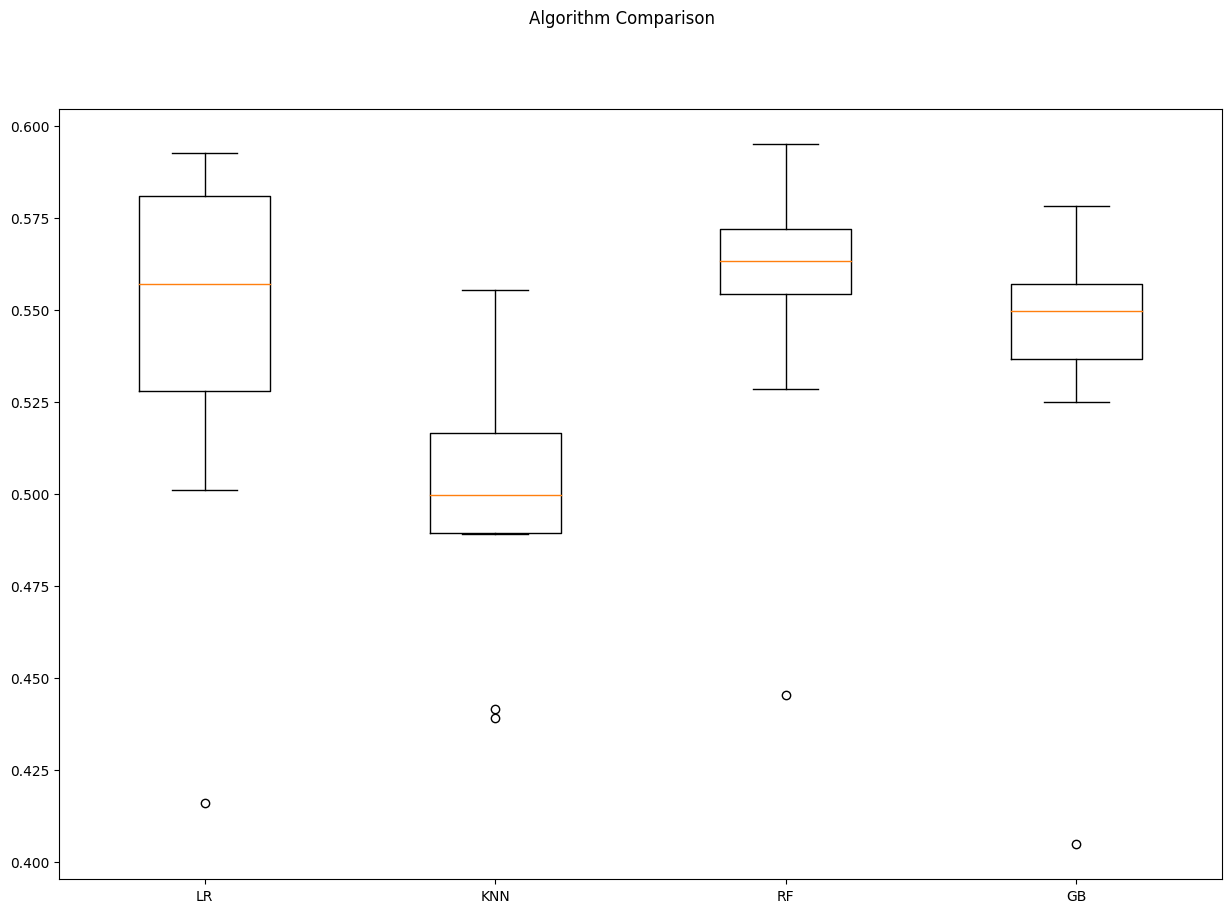

In [16]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [17]:
results_dict = {name: result for name, result in zip(names, results)}

# Create the DataFrame using the dictionary
score = pd.DataFrame(results_dict)

# Print the DataFrame
display(score)

,LR,KNN,RF,GB
0,0.530410,0.490393,0.528468,0.551399
1,0.590299,0.495535,0.556071,0.536741
2,0.553026,0.519541,0.577001,0.554519
3,0.560916,0.507989,0.570975,0.547974
4,0.415910,0.438961,0.445360,0.404745
5,0.527254,0.489008,0.572271,0.536518
6,0.501016,0.441468,0.557071,0.525018
7,0.592696,0.503664,0.553905,0.563603
8,0.569607,0.555469,0.569607,0.557847
9,0.584643,0.533794,0.595067,0.578397
